In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

!pip install opencv-python pillow scikit-learn joblib


In [3]:

import os
import cv2
import numpy as np

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

# Path to dataset
dataset_path = "/content/drive/MyDrive/dataset/"
CLASSES = ["apple", "banana"]

def read_image(image_path):

    # Skip AVIF images
    if image_path.endswith('.avif'):
        print(f"Skipping AVIF image: {image_path}")
        return None

    # Use OpenCV to read WebP, JPG, PNG, BMP, etc.
    image = cv2.imread(image_path)
    return image


In [4]:

def read_image(image_path):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: could not read {image_path}")
    return image


def extract_features(image_path, bins=(8, 8, 8)):

    image = read_image(image_path)
    if image is None:
        return None

    # Resize for consistency
    image = cv2.resize(image, (128, 128))

    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 3D color histogram over H, S, V
    hist = cv2.calcHist(
        [hsv], [0, 1, 2], None,
        bins,                 # e.g. (8,8,8)
        [0, 180, 0, 256, 0, 256]
    )

    # Normalize and flatten
    cv2.normalize(hist, hist)
    return hist.flatten()


In [7]:
DATASET_PATH = "/content/drive/MyDrive/dataset/"

X = []
y = []

for label, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATASET_PATH, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
            fpath = os.path.join(class_dir, fname)
            feat = extract_features(fpath)
            if feat is not None:
                X.append(feat)
                y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", CLASSES)


Feature matrix shape: (49, 512)
Labels shape: (49,)
Classes: ['apple', 'banana']


In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 39
Test size: 10


X shape: (49, 512)
y shape: (49,)
Variance by PCA components: [0.22162835 0.09686632]
Cluster labels example: [1 1 0 1 1 0 1 1 0 0]


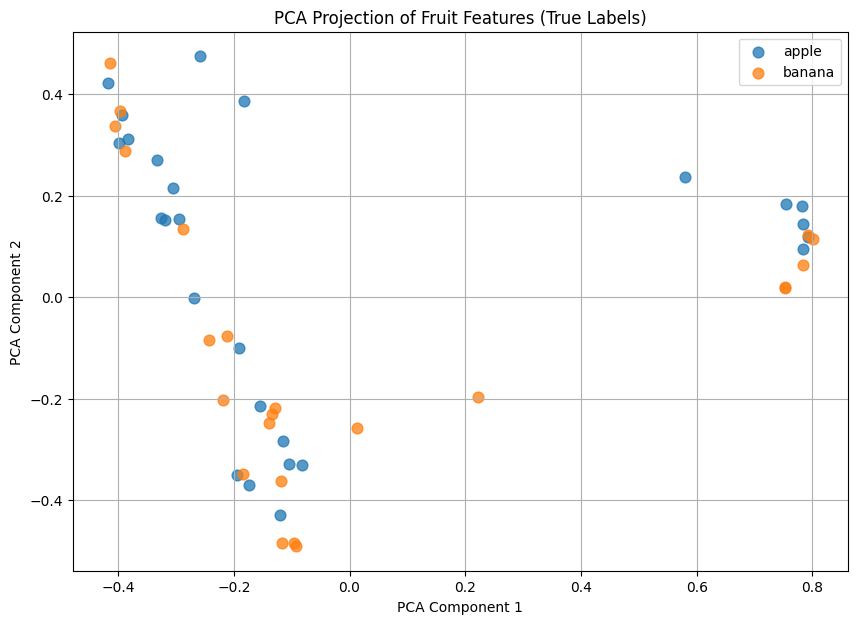

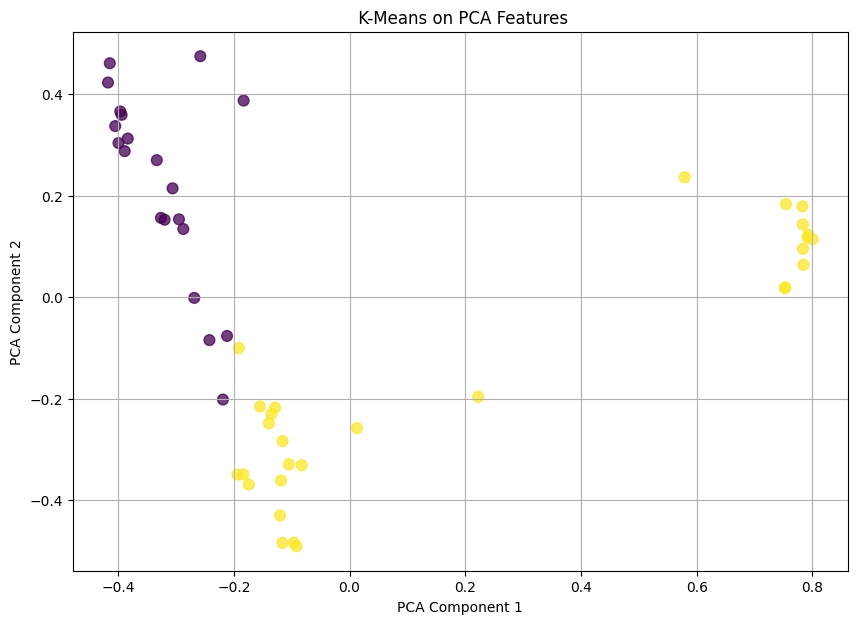

In [9]:

# PCA + K-MEANS CLUSTERING


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ensure X and y exist
print("X shape:", X.shape)
print("y shape:", y.shape)

# ---- Step 1: PCA to 2D ----
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

print("Variance by PCA components:", pca.explained_variance_ratio_)


# ---- Step 2: K-Means clustering
kmeans = KMeans(n_clusters=len(CLASSES), random_state=42)
cluster_labels = kmeans.fit_predict(X)

print("Cluster labels example:", cluster_labels[:10])


# ---- Step 3A: Visualize TRUE LABELS ----
plt.figure(figsize=(10, 7))

for class_index, class_name in enumerate(CLASSES):
    idx = (y == class_index)
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=class_name,
        alpha=0.75,
        s=60
    )

plt.title("PCA Projection of Fruit Features (True Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


# ---- Step 3B: Visualize CLUSTERS ----
plt.figure(figsize=(10, 7))

plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=cluster_labels,
    cmap="viridis",
    alpha=0.75,
    s=60
)

plt.title(" K-Means on PCA Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


Training model: SVM (RBF)
Accuracy (SVM (RBF)): 60.00%

Classification report:
              precision    recall  f1-score   support

       apple       0.60      0.60      0.60         5
      banana       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10



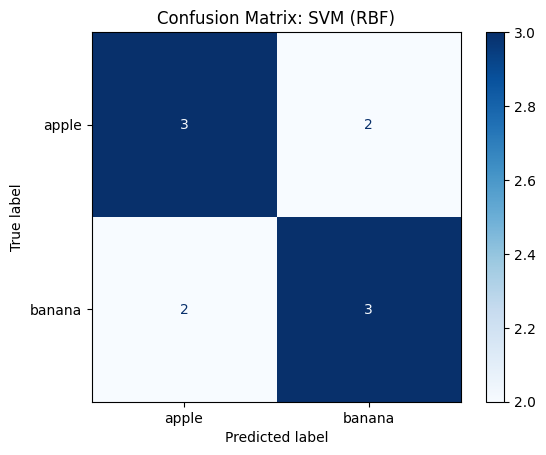

Training model: k-NN (k=5)
Accuracy (k-NN (k=5)): 70.00%

Classification report:
              precision    recall  f1-score   support

       apple       1.00      0.40      0.57         5
      banana       0.62      1.00      0.77         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



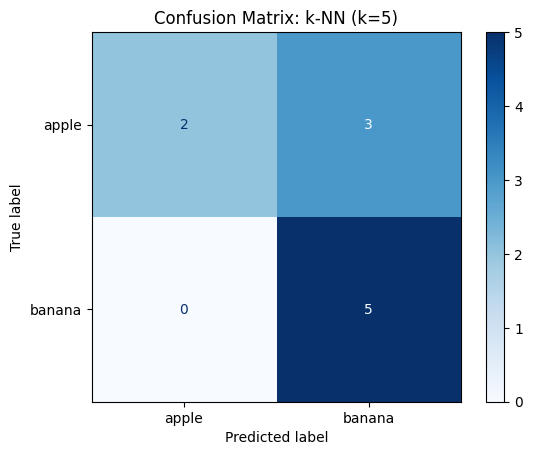

Training model: Random Forest
Accuracy (Random Forest): 90.00%

Classification report:
              precision    recall  f1-score   support

       apple       0.83      1.00      0.91         5
      banana       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



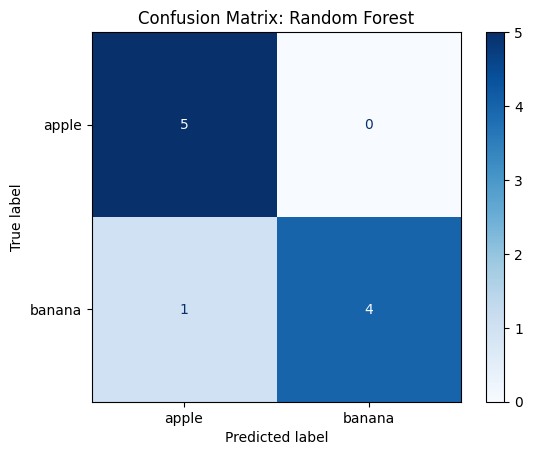

SVM (RBF): 60.00%
k-NN (k=5): 70.00%
Random Forest: 90.00%


In [10]:
# Define models
models = {
    "SVM (RBF)": SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        probability=True,
        random_state=42
    ),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print("=" * 60)
    print(f"Training model: {name}")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({name}): {acc * 100:.2f}%")

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=CLASSES))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    results[name] = (model, acc)

print("=" * 60)
for name, (_, acc) in results.items():
    print(f"{name}: {acc * 100:.2f}%")


In [11]:
# Pick and save best model
best_name = max(results, key=lambda k: results[k][1])
best_model, best_acc = results[best_name]

print(f"\nBest model: {best_name} with accuracy {best_acc * 100:.2f}%")

# Save to Drive
MODEL_PATH  = "/content/drive/MyDrive/best_fruit_model.pkl"
SCALER_PATH = "/content/drive/MyDrive/feature_scaler.pkl"
CLASSES_PATH = "/content/drive/MyDrive/fruit_classes.pkl"

joblib.dump(best_model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(CLASSES, CLASSES_PATH)

print("Saved model to:", MODEL_PATH)
print("Saved scaler to:", SCALER_PATH)
print("Saved class names to:", CLASSES_PATH)



Best model: Random Forest with accuracy 90.00%
Saved model to: /content/drive/MyDrive/best_fruit_model.pkl
Saved scaler to: /content/drive/MyDrive/feature_scaler.pkl
Saved class names to: /content/drive/MyDrive/fruit_classes.pkl


In [12]:
from google.colab import files
files.download(MODEL_PATH)
files.download(SCALER_PATH)
files.download(CLASSES_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Function to classify a single external image and visualize
def classify_external_image(image_path):
    # Load model, scaler, classes
    model   = joblib.load(MODEL_PATH)
    scaler  = joblib.load(SCALER_PATH)
    classes = joblib.load(CLASSES_PATH)

    # Extract features
    feat = extract_features(image_path)
    if feat is None:
        print("Could not extract features from image.")
        return

    feat_scaled = scaler.transform([feat])
    pred_idx = model.predict(feat_scaled)[0]

    # If model supports probabilities
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(feat_scaled)[0]
        prob_dict = {cls: float(p) for cls, p in zip(classes, probs)}
    else:
        prob_dict = None

    predicted_class = classes[pred_idx]
    print("Predicted class:", predicted_class)
    if prob_dict is not None:
        print("Class probabilities:", prob_dict)

    # Show image with prediction text
    img = cv2.imread(image_path)
    if img is None:
        print("Could not read image for display.")
        return

    cv2.putText(
        img,
        f"Pred: {predicted_class}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2
    )

    cv2_imshow(img)


Predicted class: apple
Class probabilities: {'apple': 0.545, 'banana': 0.455}


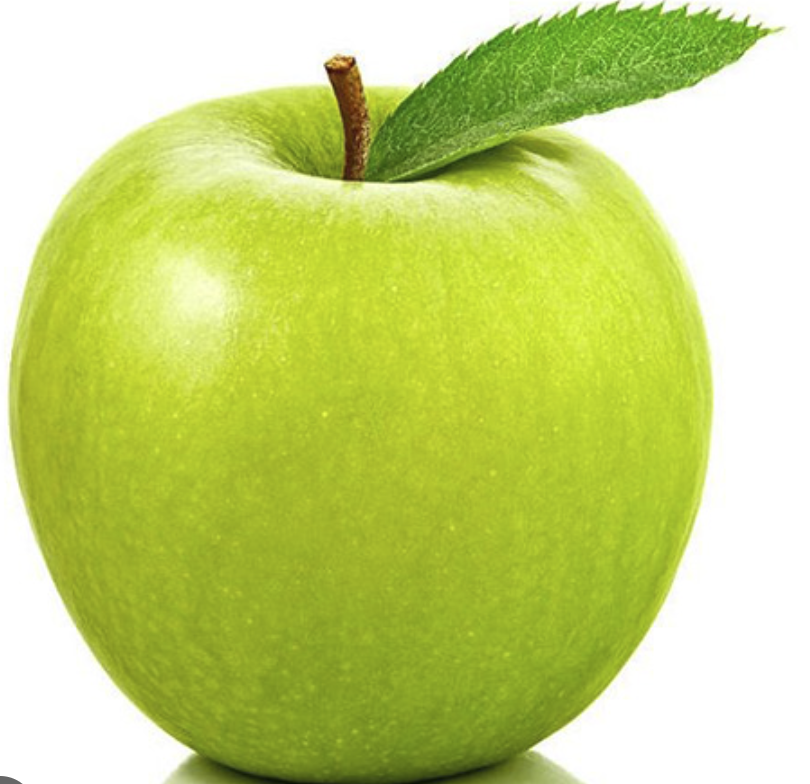

In [ ]:
# Test
test_img = "/content/Screenshot 2025-12-03 at 12.19.12.png"
classify_external_image(test_img)
